# Introduction

What is Root Mean Square Error (RMSE)? According to Wikipedia:

"The root-mean-square deviation (RMSD) or root-mean-square error (RMSE) is a frequently used measure of the differences between values (sample or population values) predicted by a model or an estimator and the values observed." https://en.wikipedia.org/wiki/Root-mean-square_deviation

In laymans terms, this means RMSE is used to determine how accurate predicted values are in comparison to the actual values recorded. A RMSE value of 0 means the predicted and observed values are perfectly aligned, and a higher RMSE value means less alignment, and ultimately, less accuracy in the model.

So, ideally, we want an unlikely score...

<center>
<img 
src="https://d14d5nk8lue86f.cloudfront.net/s3fs-public/2021-12/Risk%20Factors%20Still%20Matter%20for%20Patients%20With%20Zero%20CAC%20Score%20MESA.jpg" 
width=1300 height=700 />
</center>

Not too hard, right?

# The Data

In [80]:
import numpy as np 
import pandas as pd
import seaborn as sns
import random
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import SGDOneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
data = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [53]:
# creating a copy of the sample submission
copy = data.copy()
# after reviewing other submissions, there are a limited number of columns that actually impact the accuracy of the model
#https://www.kaggle.com/code/vasudevak/we-messed-up-while-trying-to-avoid-data-leakage
#https://www.kaggle.com/code/arunklenin/in-depth-analysis-five-anomaly-detection-methods
bad_cols = ['id', 'O2_1', 'O2_2', 'BOD5_5','NO3_6', 'target']
for col in copy.columns:
    if col not in bad_cols:
        copy[col] = 0
copy.head()

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.500,9.00,0,0,0,0,0,0,...,0,1.730,0,0,0,0,0,16.645,0,0
1,1,9.10,13.533,40.90,0,0,0,0,0,0,...,0,9.530,0,0,0,0,0,5.725,0,0
2,2,8.21,3.710,5.42,0,0,0,0,0,0,...,0,3.025,0,0,0,0,0,6.750,0,0
3,3,8.39,8.700,8.10,0,0,0,0,0,0,...,0,2.070,0,0,0,0,0,8.670,0,0
4,4,8.07,8.050,8.65,0,0,0,0,0,0,...,0,1.730,0,0,0,0,0,8.400,0,0


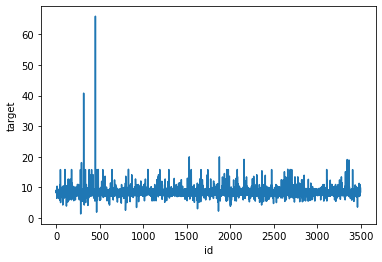

In [39]:
#let's plot these values
plt.xlabel('id')
plt.ylabel('target')
sns.lineplot(data=copy, x='id', y='target')
plt.show()

In [47]:
#there seem to be a couple of outliers, so let's try removing them. Following the method outlined in https://www.kaggle.com/code/achusanjeev/best-hyperparameter-tuning-for-this-dataset:
svm = SGDOneClassSVM(nu=0.1).fit(copy.drop(['id'],axis=1))
copy['svm_anomaly'] = svm.predict(copy.drop(['id'],axis=1))
len(np.where(copy['svm_anomaly']==-1)[0])
If = IsolationForest(contamination=0.005).fit(copy.drop(['id','svm_anomaly'],axis=1))
copy['if_anomaly'] = If.predict(copy.drop(['id','svm_anomaly'],axis=1))
len(np.where(copy['if_anomaly']==-1)[0])
lof = LocalOutlierFactor(contamination=0.005)
copy['lof_anomaly'] = lof.fit_predict(copy.drop(['id','svm_anomaly','if_anomaly'],axis=1))
len(np.where(copy['lof_anomaly']==-1)[0])
lowest_quality_labels = [3366, 2365,  465, 1776, 1295,  800, 2306,  402, 1215, 1737, 3212,  529,  482, 2068, 1163, 1408, 2246, 1681,  162]

/Users/sola/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [49]:
rows_to_remove = np.union1d(np.union1d(np.union1d(np.where(copy['svm_anomaly']==-1),np.where(copy['if_anomaly']==-1)),np.where(copy['lof_anomaly']==-1)),lowest_quality_labels)
rows_to_remove

array([ 135,  162,  282,  316,  320,  336,  351,  365,  381,  402,  433,
        451,  465,  482,  529,  541,  608,  613,  692,  729,  749,  797,
        800,  807,  866,  879,  948,  967, 1146, 1163, 1168, 1178, 1215,
       1248, 1295, 1408, 1593, 1608, 1621, 1625, 1662, 1681, 1707, 1737,
       1776, 1803, 1828, 1866, 1876, 2006, 2068, 2100, 2119, 2246, 2306,
       2365, 2477, 2494, 2513, 2548, 2629, 2687, 2768, 2867, 3076, 3125,
       3212, 3305, 3318, 3346, 3366, 3408, 3440, 3464])

In [83]:
data_dropped = copy.drop(index=rows_to_remove)
data_clean = copy

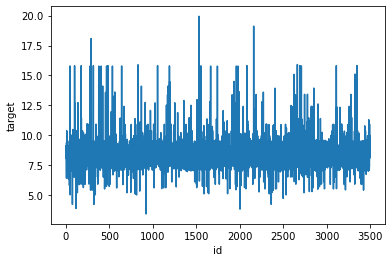

In [73]:
plt.xlabel('id')
plt.ylabel('target')
sns.lineplot(data=data_dropped, x='id', y='target')
plt.show()

In [ ]:
#This looks like a much more evenly distributed chart :)

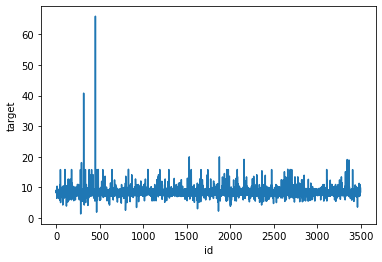

In [78]:
plt.xlabel('id')
plt.ylabel('target')
sns.lineplot(data=data, x='id', y='target')
plt.show()

In [74]:
#This looks like a much more even distribution of values :)
#but let's run a qucik rmse check to see how much better these values are:
def rmse(predictions, targets):
    return np.sqrt(np.mean((predictions-targets)**2))

In [84]:
print(f"RMSE Score without the identified outliers is {rmse(test, data)}")

RMSE Score without the identified outliers is BOD5_1     2.548126
BOD5_2     2.069674
BOD5_3     3.285012
BOD5_4     3.837249
BOD5_5     4.729734
BOD5_6     2.109677
BOD5_7     4.461106
Id              NaN
NH4_1      0.429346
NH4_2      0.656482
NH4_3      2.698428
NH4_4      5.365664
NH4_5     10.811939
NH4_6      1.411784
NH4_7      0.831603
NO2_1      0.120363
NO2_2      0.306745
NO2_3      1.091871
NO2_4      3.710805
NO2_5      1.712904
NO2_6      0.311741
NO2_7      0.600330
NO3_1      3.848085
NO3_2      3.750844
NO3_3      4.571169
NO3_4      9.141472
NO3_5      9.562493
NO3_6      5.370195
NO3_7      7.262385
O2_1       3.150227
O2_2       7.948496
O2_3       3.736563
O2_4       3.633856
O2_5       4.071126
O2_6       8.524925
O2_7       4.217357
id              NaN
target          NaN
dtype: float64


/Users/sola/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [85]:
print(f"RMSE Score without the identified outliers is {rmse(test, data_clean)}")

RMSE Score without the identified outliers is BOD5_1     5.555688
BOD5_2     5.338054
BOD5_3     4.865383
BOD5_4     6.416272
BOD5_5     4.729734
BOD5_6     4.510116
BOD5_7     6.511317
Id              NaN
NH4_1      0.545614
NH4_2      0.595038
NH4_3      2.890554
NH4_4      5.831007
NH4_5      8.753707
NH4_6      1.609740
NH4_7      1.148798
NO2_1      0.140469
NO2_2      0.250737
NO2_3      1.115069
NO2_4      3.987108
NO2_5      1.727223
NO2_6      0.343703
NO2_7      0.625013
NO3_1      4.256028
NO3_2      4.593570
NO3_3      4.793806
NO3_4      8.636710
NO3_5      8.125787
NO3_6      5.370195
NO3_7      8.368743
O2_1       3.150227
O2_2       7.948496
O2_3      10.556765
O2_4       9.072163
O2_5       7.343050
O2_6       9.714952
O2_7       8.364019
id              NaN
target          NaN
dtype: float64


/Users/sola/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [79]:
data_dropped.to_csv('submission.csv',index=False)